In [1]:
import numpy as np
import matplotlib.pyplot as plt

train_file = "clustering_data/EMGaussian.train"
test_file = "clustering_data/EMGaussian.test"

def preprocess(lines):
    points = [line.strip().split(' ') for line in lines]
    return np.array(points, dtype=np.float)

with open(train_file) as f1, open(test_file) as f2:
    X_train = preprocess(f1.readlines())
    X_test = preprocess(f2.readlines())

In [2]:
# Emission parameters (Gaussians)
mu = np.array([[-2.0344, 4.1726],
               [3.9779, 3.7735],
               [3.8007, -3.7972],
               [-3.0620, -3.5345]])
sigma = np.array([[[2.9044, 0.2066],
                   [0.2066, 2.7562]],
                  [[0.2104, 0.2904],
                   [0.2904, 12.2392]],
                  [[0.9213, 0.0574],
                   [0.0574, 1.8660]],
                  [[6.2414, 6.0502],
                   [6.0502, 6.1825]]])

# Start state parameters
pi = np.ones(4) / 4

# Transition parameters
A = np.ones((4, 4)) / 6 + np.diag(np.ones(4) / 3)

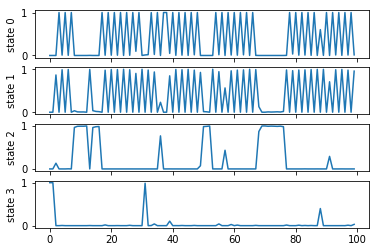

In [3]:
import math
from numpy.linalg import det, inv

def obs_probas(x, mu, sigma):
    probas = []
    for k in xrange(mu.shape[0]):
        diff = mu[k] - x
        sigma_inv = inv(sigma[k])
        exp_term = - diff.dot(sigma_inv).dot(diff) / 2
        d = x.shape[0]
        scaling = (2 * math.pi) ** (d / 2.) * det(sigma_inv) ** (1. / 2)
        probas.append(scaling * math.exp(exp_term))
    return np.array(probas)

""" T = number of time steps
    k = number of hidden states
    d = number of dimensions of observations
    Inputs:
        X of shape (T, d)
        pi of shape (k,)
        A of shape (k, k) 
        mu of shape (k, d)
        sigma of shape (k, d, d) 
    Output:
        alpha of shape (T, k)
    """
def alpha_recursion(X, pi, A, mu, sigma):
    # Compute alpha at time step 1
    alpha = [pi * obs_probas(X[0], mu, sigma)]
    # Compute log alpha from time steps 2 to T
    for t in xrange(1, X.shape[0]):
        alpha.append(obs_probas(X[t], mu, sigma) * A.dot(alpha[-1]))  
    return np.array(alpha)

""" Output:
        beta of shape (T, k)
    """
def beta_recursion(X, A, mu, sigma):
    # Initialize beta at time step T
    beta = [np.ones(A.shape[0])]
    # Compute beta from time steps T-1 to 1
    for t in xrange(X.shape[0]-2, -1, -1):
        beta.append(A.T.dot(beta[-1] * obs_probas(X[t+1], mu, sigma))) 
    # Put log beta list in order 1 to T
    beta.reverse()
    return np.array(beta)

# Compute p(z_t, x_1:T)
alpha = alpha_recursion(X_test, pi, A, mu, sigma)
beta = beta_recursion(X_test, A, mu, sigma)
joint_p = alpha * beta

# Normalize to get p(z_t | x_1:T)
cond_p = joint_p / joint_p.sum(axis=1, keepdims=True)

# Plot p(z_t | x_1:T) for first 100 time steps
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True)
ax1.plot(xrange(100), cond_p[:100, 0])
ax1.set_ylabel("state 0")
ax2.plot(xrange(100), cond_p[:100, 1])
ax2.set_ylabel("state 1")
ax3.plot(xrange(100), cond_p[:100, 2])
ax3.set_ylabel("state 2")
ax4.plot(xrange(100), cond_p[:100, 3])
ax4.set_ylabel("state 3")
plt.show()

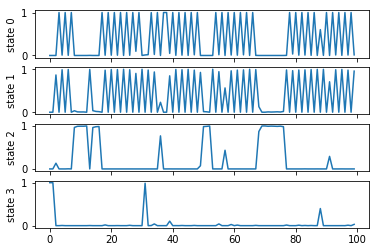

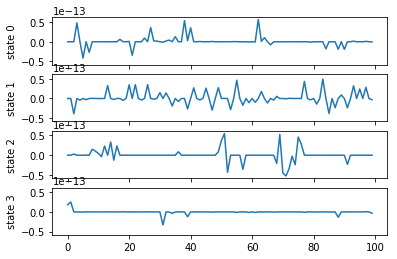

In [4]:
# Introduce log sum exp trick to avoid underflow 
from scipy.special import logsumexp

def matrix_vector_product_logsumexp(log_A, log_x):
    return logsumexp(log_A + log_x.reshape(1, -1), axis=1)

    #B = log_A + log_x.reshape(1, -1)
    #max_vect = np.max(B, axis=1)
    #B = np.exp(B - max_vect.reshape(-1, 1))
    #y = np.sum(B, axis=1)
    #return np.log(y) + max_vect
    
def log_alpha_recursion(X, pi, A, mu, sigma):
    log_A = np.log(A)
    # Compute log alpha at time step 1
    log_alpha = [np.log(pi) + np.log(obs_probas(X[0], mu, sigma))]
    # Compute log alpha from time steps 2 to T
    for t in xrange(1, X.shape[0]):
        log_alpha.append(
            np.log(obs_probas(X[t], mu, sigma)) + \
            matrix_vector_product_logsumexp(log_A, log_alpha[-1]))
    return np.array(log_alpha)

def log_beta_recursion(X, A, mu, sigma):
    log_A = np.log(A)
    # Initialize log beta at time step T
    log_beta = [np.zeros(A.shape[0])]
    # Compute log beta from time steps T-1 to 1
    for t in xrange(X.shape[0]-2, -1, -1):
        log_beta.append(matrix_vector_product_logsumexp(log_A.T, 
            log_beta[-1] + np.log(obs_probas(X[t+1], mu, sigma))))
    # Put log beta list in order 1 to T
    log_beta.reverse()
    return np.array(log_beta)

""" Output : matrix of shape (T, k)
             where index (t, i) is p(z_t=i | x_1:T)
    """
def compute_conditional_probas(X, pi, A, mu, sigma):
    # Compute log p(z_t, x_1:T)
    log_alpha = log_alpha_recursion(X, pi, A, mu, sigma)
    log_beta = log_beta_recursion(X, A, mu, sigma)
    log_joint_p = log_alpha + log_beta
    # Normalize to get log p(z_t | x_1:T)
    log_cond_p = log_joint_p - logsumexp(log_joint_p, axis=1, keepdims=True)
    # Finally exponentiate to get p(z_t | x_1:T)
    cond_p = np.exp(log_cond_p)
    return cond_p

cond_p2 = compute_conditional_probas(X_test, pi, A, mu, sigma)

# Plot p(z_t | x_1:T) for first 100 time steps
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True)
ax1.plot(xrange(100), cond_p2[:100, 0])
ax1.set_ylabel("state 0")
ax2.plot(xrange(100), cond_p2[:100, 1])
ax2.set_ylabel("state 1")
ax3.plot(xrange(100), cond_p2[:100, 2])
ax3.set_ylabel("state 2")
ax4.plot(xrange(100), cond_p2[:100, 3])
ax4.set_ylabel("state 3")
plt.show()

# Plot difference between p(z_t | x_1:T) computed with log trick 
# and computed with no trick
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True)
ax1.plot(xrange(100), cond_p2[:100, 0] - cond_p[:100, 0])
ax1.set_ylabel("state 0")
ax2.plot(xrange(100), cond_p2[:100, 1] - cond_p[:100, 1])
ax2.set_ylabel("state 1")
ax3.plot(xrange(100), cond_p2[:100, 2] - cond_p[:100, 2])
ax3.set_ylabel("state 2")
ax4.plot(xrange(100), cond_p2[:100, 3] - cond_p[:100, 3])
ax4.set_ylabel("state 3")
plt.show()

In [5]:
from sklearn.preprocessing import normalize

class HMM():
    def __init__(self):
        # Initialize parameters
        self.mu = np.array([[-2.0344, 4.1726],
                            [3.9779, 3.7735],
                            [3.8007, -3.7972],
                            [-3.0620, -3.5345]])
        self.sigma = np.array([[[2.9044, 0.2066],
                                [0.2066, 2.7562]],
                               [[0.2104, 0.2904],
                                [0.2904, 12.2392]],
                               [[0.9213, 0.0574],
                                [0.0574, 1.8660]],
                               [[6.2414, 6.0502],
                                [6.0502, 6.1825]]])
        self.A = np.ones((4, 4)) / 6 + np.diag(np.ones(4) / 3)
        self.pi = np.ones(4) / 4
        
    def fit(self, X, X_test, threshold=1e-6):
        # Keep track of log likelihood under model as we train
        log_likelihoods_train = [self._EStep(X)]
        log_likelihoods_test = [self._log_likelihood(X_test)]
        self._MStep(X)
        log_like = self._EStep(X)
        while log_like - log_likelihoods_train[-1] > threshold:
            log_likelihoods_train.append(log_like)
            log_likelihoods_test.append(self._log_likelihood(X_test))
            self._MStep(X)
            log_like = self._EStep(X)
        return log_likelihoods_train, log_likelihoods_test
        
    def _MStep(self, X):
        self.pi = self.state_w[0]
        self.A = normalize(np.sum(self.transition_w, axis=0), 
                           norm='l1', axis=0)
        self.mu = self.state_w.T.dot(X) / \
            self.state_w.T.sum(axis=1, keepdims=True)
        # Compute the covariance matrix for each cluster in turn
        self.sigma = []
        for j in xrange(self.mu.shape[0]):
            dist = X - self.mu[j]
            sigma_j = dist.T.dot(dist * self.state_w[:, j].reshape(-1, 1))
            sigma_j = sigma_j / np.sum(self.state_w[:, j])
            self.sigma.append(sigma_j)
        self.sigma = np.array(self.sigma)
        # Might be useful to avoid nan in the case all weights 
        # for a cluster are 0 (shouldn't happen)
        self.sigma[np.isnan(self.sigma)] = 25
            
    """ Compute soft counts for states and transitions
        and return log likelihood of data with current parameters 
        """
    def _EStep(self, X):
        # Compute log alpha and beta for every time step
        log_alpha = log_alpha_recursion(X, self.pi, self.A, 
                                        self.mu, self.sigma)
        log_beta = log_beta_recursion(X, self.A, self.mu, self.sigma)
        
        # Compute soft counts from log alpha and beta
        # Matrix of shape (T, k) containing weights tau_{t,i}
        self.state_w = self._state_probas(log_alpha, log_beta)
        # Matrix of shape (T-1, k, k) containing weights tau_{t,i,j}
        self.transition_w = self._transition_probas(X, log_alpha, log_beta)
        
        # Compute log likelihood of data from alpha_T
        log_likelihood = logsumexp(log_alpha[-1, :])
        return log_likelihood
        
    """ Compute tau_{t,i} = p(z_t=i | x_1:T) for all t, i
        Returns a matrix of shape (T, k)
        """
    def _state_probas(self, log_alpha, log_beta):
        # Compute log p(z_t, x_1:T)
        log_joint_p = log_alpha + log_beta
        # Normalize to get log p(z_t | x_1:T)
        log_cond_p = log_joint_p - logsumexp(log_joint_p, axis=1, keepdims=True)
        # Finally exponentiate to get p(z_t | x_1:T)
        cond_p = np.exp(log_cond_p)
        return cond_p
    
    """ Compute tau_{t,i,j} = p(z_t=i, z_t-1=j | x_1:T) for all t, i, j
        where t ranges from 2 to T
        Returns a matrix of shape (T-1, k, k)
        """
    def _transition_probas(self, X, log_alpha, log_beta):
        # Compute log p(z_t, z_t-1, x_1:T)
        # (Very careful use of broadcasting)
        log_joint_p = np.log(self.A) + \
            np.log(self._obs_probas(X[1:]))[:,:,np.newaxis] + \
            log_alpha[:-1,np.newaxis,:] + log_beta[1:,:,np.newaxis]
        # Normalize to get log p(z_t, z_t-1 | x_1:T)
        log_cond_p = log_joint_p - logsumexp(log_joint_p, axis=(1,2), keepdims=True)
        # Finally exponentiate to get p(z_t, z_t-1 | x_1:T)
        cond_p = np.exp(log_cond_p)
        return cond_p
        
    """ Compute p(x_t | z_t=i) for all t, i
        Input:
            X of shape (T, d)
        Output:
            matrix of shape (T, k)
        """
    def _obs_probas(self, X):
        probas = []
        for k in xrange(self.mu.shape[0]):
            diff = X - self.mu[k]
            sigma_inv = inv(self.sigma[k])
            exp_term = - np.diag(diff.dot(sigma_inv).dot(diff.T)) / 2
            d = X.shape[1]
            scaling = (2 * math.pi) ** (d / 2.) * det(sigma_inv) ** (1. / 2)
            probas.append(scaling * np.exp(exp_term)) 
        return np.array(probas).T
        
    def _log_likelihood(self, X):
        log_alpha = log_alpha_recursion(X, self.pi, self.A, 
                                        self.mu, self.sigma)
        log_likelihood = logsumexp(log_alpha[-1, :])
        return log_likelihood
    
    def viterbi_decoding(self, X):
        log_A = np.log(self.A)
        # Initialize tables
        k, T = self.mu.shape[0], X.shape[0]
        T1 = np.zeros((k, T))
        T2 = np.zeros((k, T)) # Backpointers
        T1[:, 0] = np.log(self.pi) + \
            np.log(self._obs_probas(X[0].reshape(1, -1))).reshape(-1)
        # Fill in tables 
        for t in xrange(1, T):
            T1[:, t] = np.log(
                self._obs_probas(X[t].reshape(1, -1)).reshape(-1)) + \
                np.max(log_A + T1[:, t-1], axis=1)
            T2[:, t] = np.argmax(log_A + T1[:, t-1], axis=1)
        # Retrieve most likely sequence
        output = [np.argmax(T1[:, -1])]
        for t in xrange(T-1, 0, -1):
            output.append(T2[int(output[-1]), t])
        output.reverse()
        return np.array(output)
    
    def compute_state_probas(self, X):
        log_alpha = log_alpha_recursion(X, self.pi, self.A, 
                                        self.mu, self.sigma)
        log_beta = log_beta_recursion(X, self.A, self.mu, self.sigma)
        return self._state_probas(log_alpha, log_beta)

-58.911637683
-117.352798638


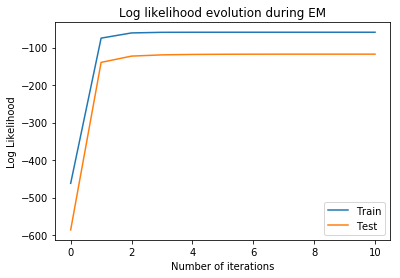

In [6]:
model = HMM()

# We also give X_test as input to the training function in order to
# compute the log likelihood on the test set at every iteration of EM
log_likelihoods_train, log_likelihoods_test = model.fit(X_train, X_test)

# Plot train and test log likelihood evolution
print(log_likelihoods_train[-1])
print(log_likelihoods_test[-1])
plt.plot(xrange(len(log_likelihoods_train)), log_likelihoods_train,
         label="Train")
plt.plot(xrange(len(log_likelihoods_test)), log_likelihoods_test,
         label="Test")
plt.title("Log likelihood evolution during EM")
plt.xlabel("Number of iterations")
plt.ylabel("Log Likelihood")
plt.legend()
plt.show()

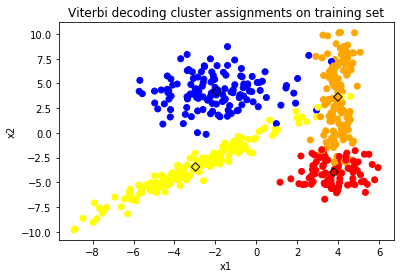

In [7]:
""" Question 8 """
z = model.viterbi_decoding(X_train)

color_map = {0: "blue", 1: "orange", 2: "red", 3: "yellow"}
plt.scatter(X_train[:, 0], X_train[:, 1], 
            c=[color_map[cluster] for cluster in z[:]])
plt.scatter(model.mu[:, 0], model.mu[:, 1], marker="D", 
                c=[color_map[i] for i in xrange(4)], edgecolor="black")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Viterbi decoding cluster assignments on training set")
plt.show()

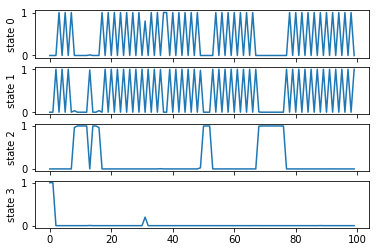

In [8]:
""" Question 9 """
cond_p = model.compute_state_probas(X_test)

# Plot p(z_t | x_1:T) for first 100 time steps for test set
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True)
ax1.plot(xrange(100), cond_p[:100, 0])
ax1.set_ylabel("state 0")
ax2.plot(xrange(100), cond_p[:100, 1])
ax2.set_ylabel("state 1")
ax3.plot(xrange(100), cond_p[:100, 2])
ax3.set_ylabel("state 2")
ax4.plot(xrange(100), cond_p[:100, 3])
ax4.set_ylabel("state 3")
plt.show()

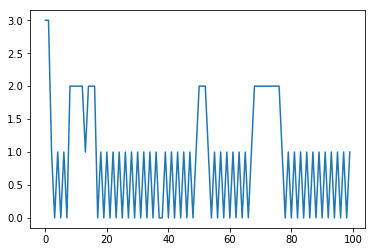

In [9]:
""" Question 10 """
# Most likely states according to conditional probabilities at each
# individual time step
most_likely_states = cond_p.argmax(axis=1)

plt.plot(xrange(100), most_likely_states[:100])
plt.show()

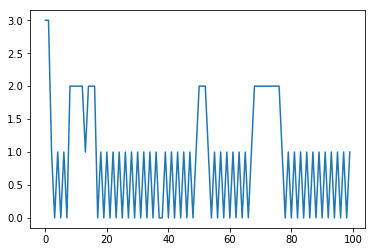

In [10]:
""" Question 11 """
# Most likely sequence of states according to Viterbi algorithm
z = model.viterbi_decoding(X_test)

plt.plot(xrange(100), z[:100])
plt.show()